In [5]:
import csv
import os

import cv2
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from utils.metrics import  iou
from scipy.spatial import cKDTree

from dataManager import FolderDataManager
from maskPredictor import MaskPredictor

def visualizer(generator):
    for data in generator:
        visualize(data)

def visualize(data):
    fig = plt.figure(constrained_layout=True, figsize=(18, 12))
    gs = fig.add_gridspec(4, 4)
    ax_orig = fig.add_subplot(gs[0:2, :2])
    ax_orig.set_title('Исходное изображение', fontsize=12)
    ax_masks = fig.add_subplot(gs[2:, 0:2])
    ax_masks.set_title('Маска', fontsize=12)
    ax_contours = fig.add_subplot(gs[:2, 2:])
    ax_contours.set_title('Рассчитанные контуры', fontsize=12)
    ax_gt = fig.add_subplot(gs[2:, 2:])
    ax_gt.set_title('GT', fontsize=12)

    ax_contours.axis('off')
    ax_orig.axis('off')
    ax_masks.axis('off')
    ax_gt.axis('off')

    keys = ['orig', 'mask',  'contours', 'gt']
    orig, mask,contours, gt = [data[key] for key in keys]
    # original
    ax_orig.clear()
    ax_orig.set_title('Исходное изображение', fontsize=12)
    ax_orig.imshow(orig, aspect='auto')
    ax_orig.axis('off')

    # masks
    ax_masks.clear()
    ax_masks.set_title('Маска', fontsize=12)
    ax_masks.imshow(mask, cmap='gray', aspect='auto')
    ax_masks.axis('off')

    # # contours
    ax_contours.clear()
    ax_contours.set_title('Рассчитанные контуры', fontsize=12)
    ax_contours.imshow(contours, aspect='auto')
    ax_contours.axis('off')

    ax_gt.clear()
    ax_gt.set_title('GT', fontsize=12)
    ax_gt.imshow(gt, aspect='auto')
    ax_gt.axis('off')



def datagen(folder_path, img_pre, mask_pre, nn_weights_path, batch_size=1, output_length=30, net='unet'):
    """Data generator: takes video and weights path and produce a tuple: masks and source """
    data_mngr = FolderDataManager(folder_path, img_pre, mask_pre)
    num = 10
    frame_generator = data_mngr.get_frames_gen(batch_size=batch_size,
                                               num=num)
    nn_model = MaskPredictor(nn_weights_path)
    masks_generator = nn_model.get_mask_gt_generator(frame_generator, th=0.7)

    iou_summ = 0
    iou_min = 1
    iou_min_num = 0
    iou_max = 0
    iou_max_num = 0
    time_avg = 0

    for i, (mask, gray, source, gt) in tqdm(enumerate(masks_generator)):
        ## contours
        contours = source.copy()
        frame = source.copy()
        mask = cv2.resize(mask, (contours.shape[1], contours.shape[0])).astype(np.uint8)

        #draw contours on final image
        cnts, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(contours, cnts, -1, (0, 255, 0), 2)

        curr_iou = iou(cv2.resize(mask, (256, 256)),
                                  cv2.resize(cv2.cvtColor(gt, cv2.COLOR_RGBA2GRAY), (256, 256)))
        iou_summ += curr_iou
        if curr_iou < iou_min:
            iou_min = curr_iou
            iou_min_num = i
        if curr_iou > iou_max:
            iou_max = curr_iou
            iou_max_num = i



        data = {'orig': source,
                'mask': mask,
                'contours':  contours,
                'gt':gt
                }
        yield data
    print("Avg IoU", iou_summ/num, "Min IoU", iou_min,"Max IoU", iou_max)


10it [00:04,  2.46it/s]


Avg IoU 1.0447159273754973e-10 Min IoU 3.166561114529241e-11 Max IoU 1.4637002339777955e-10


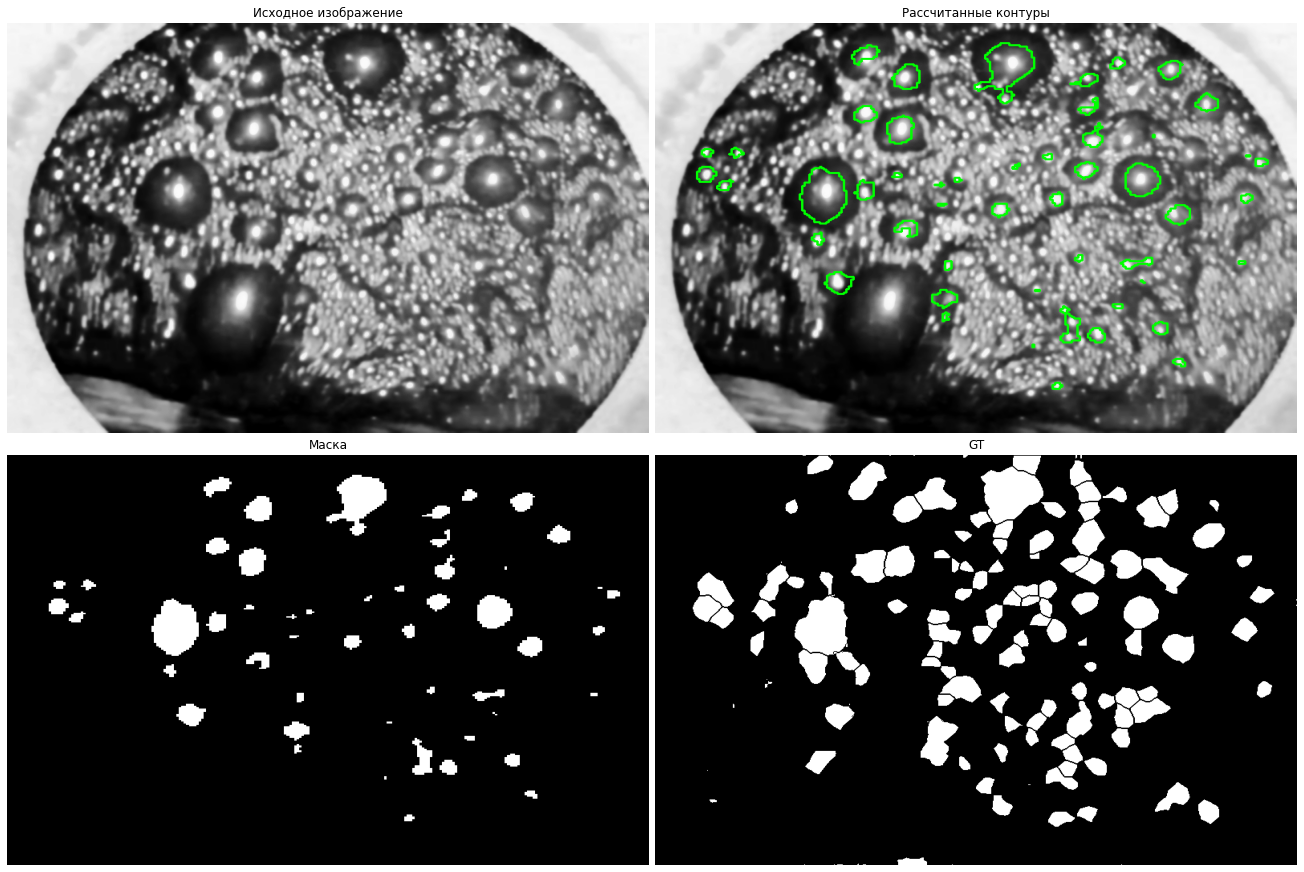

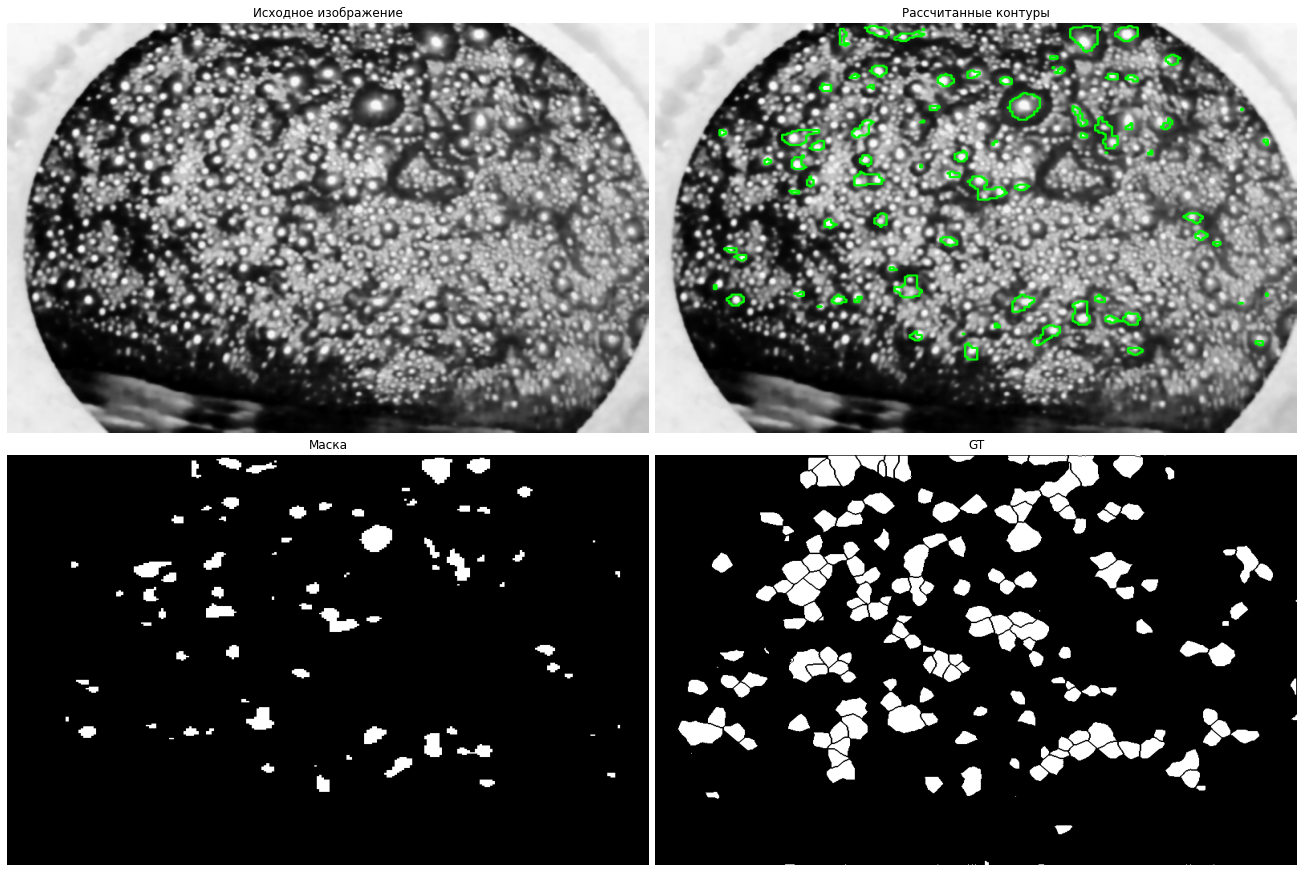

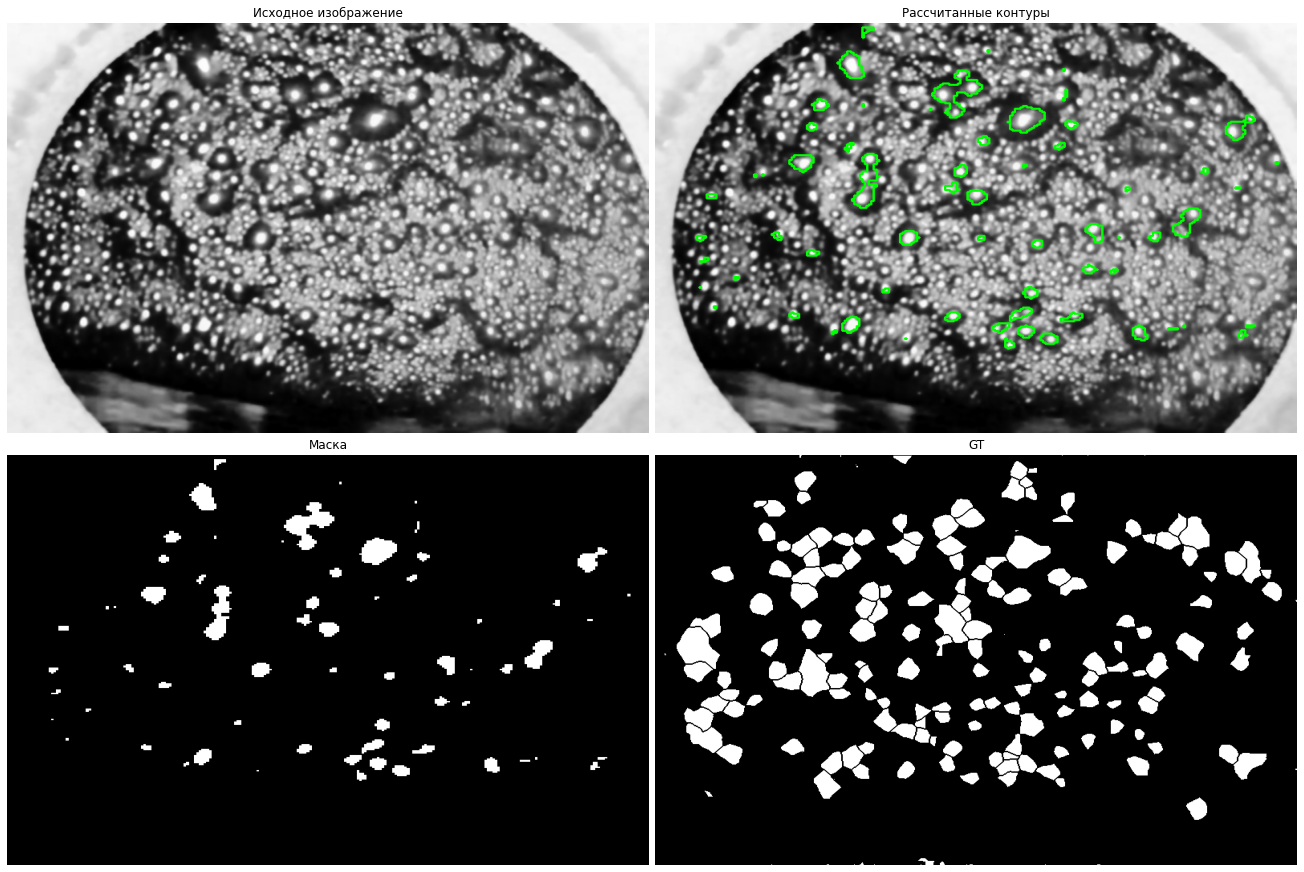

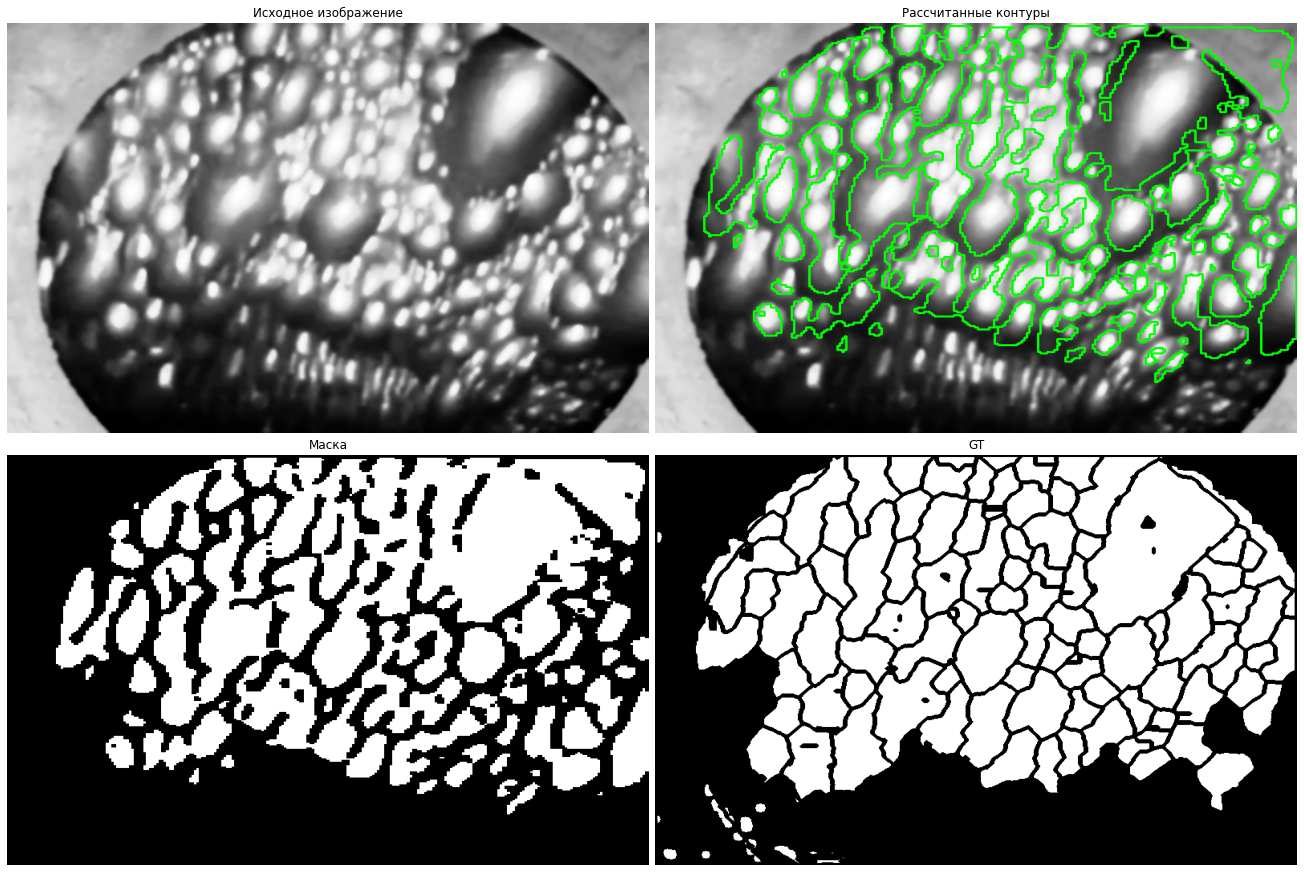

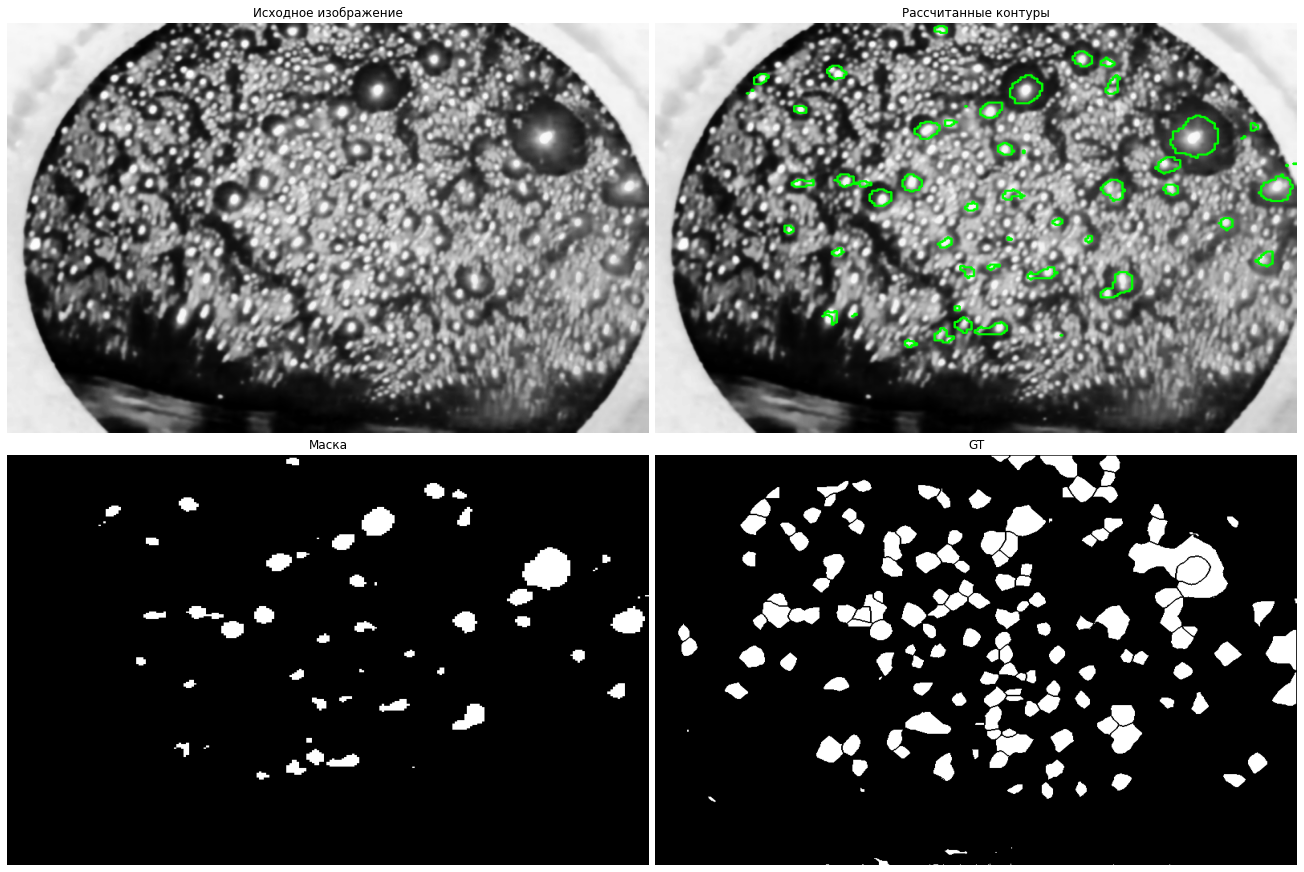

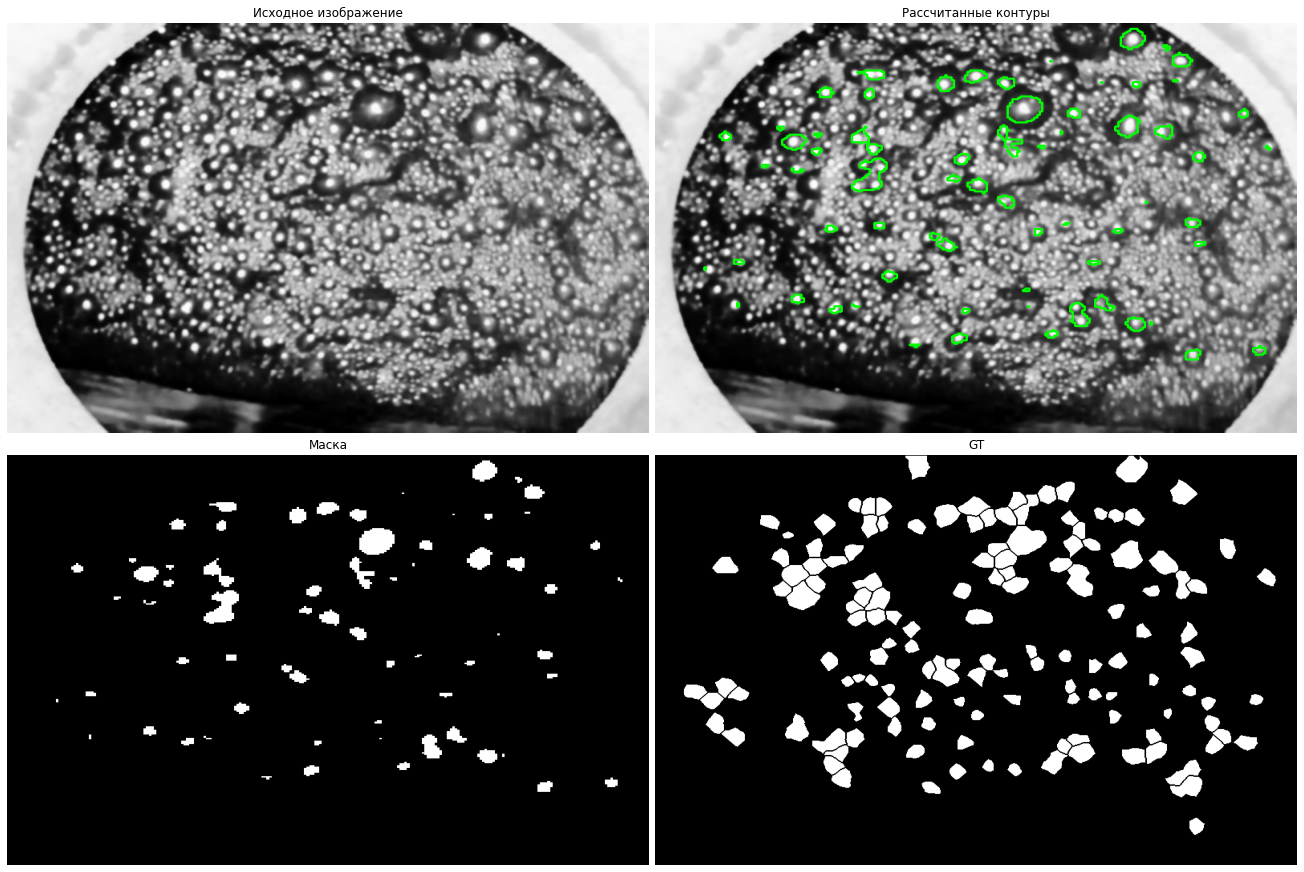

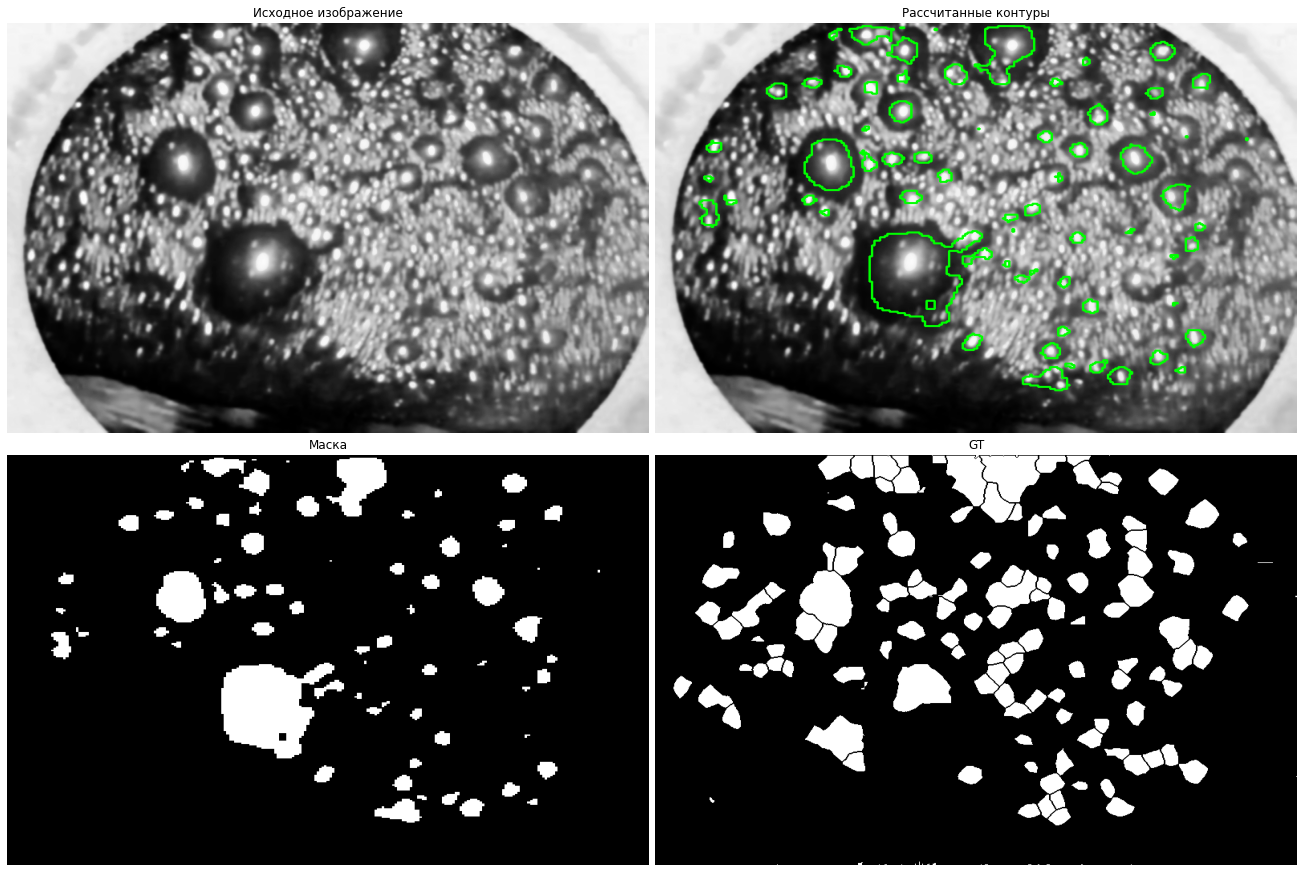

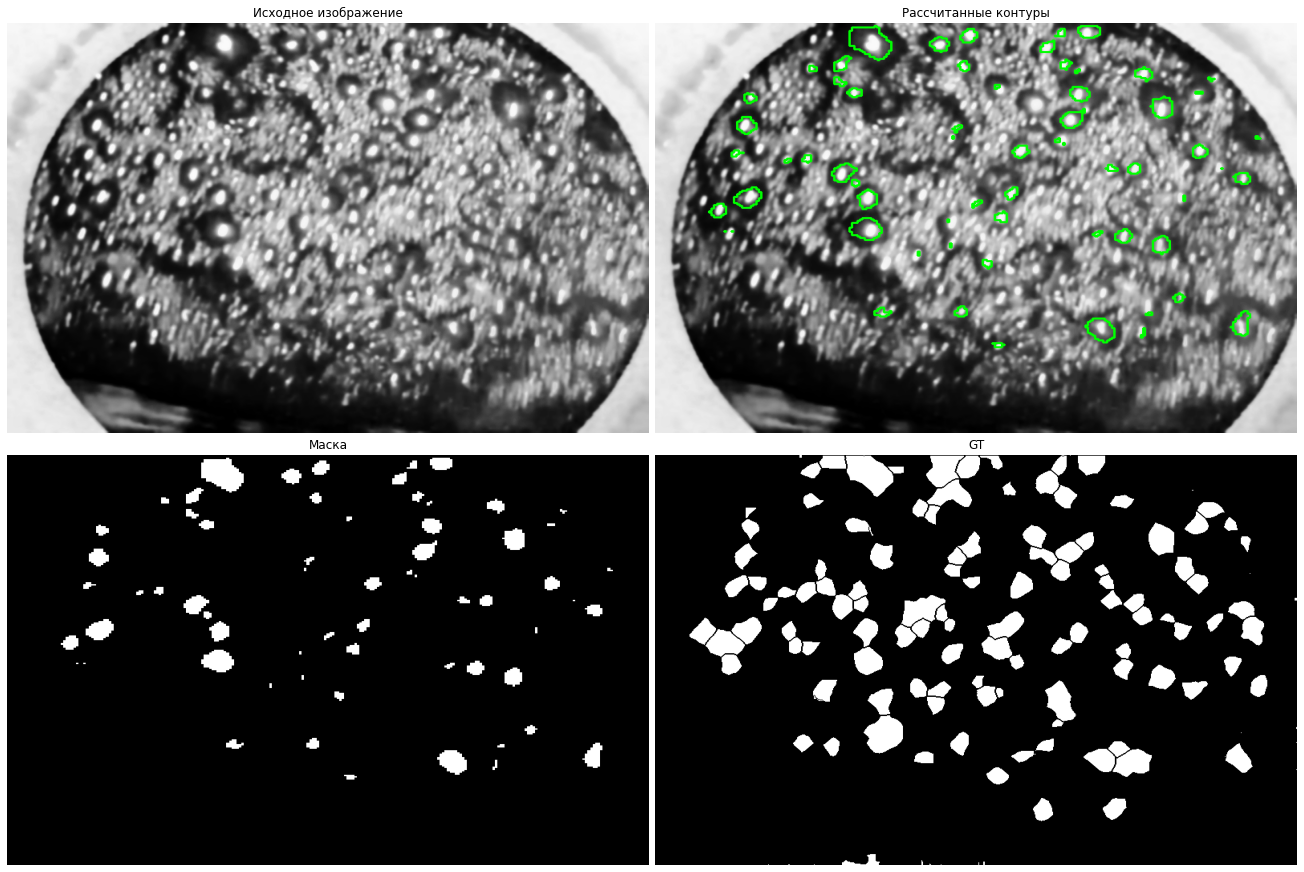

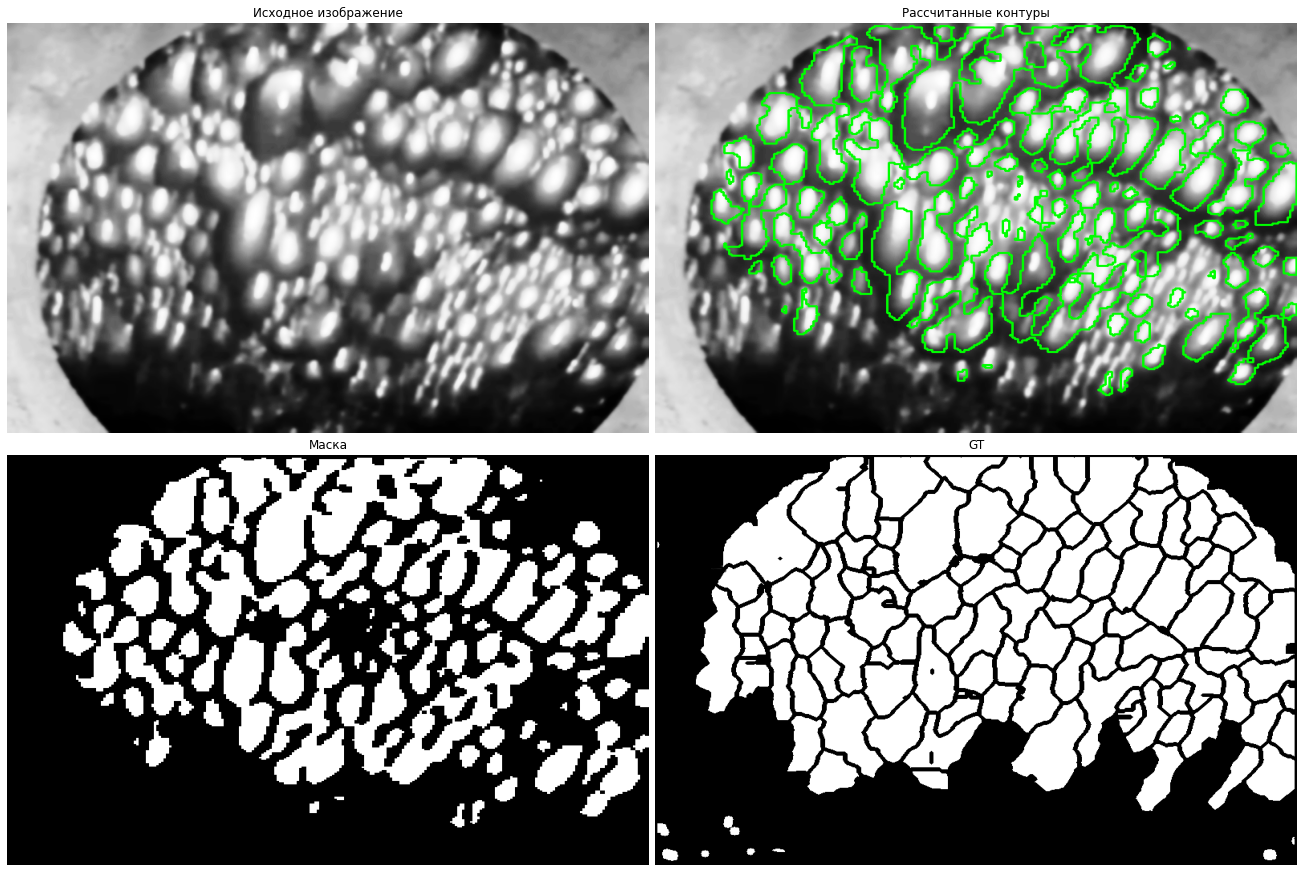

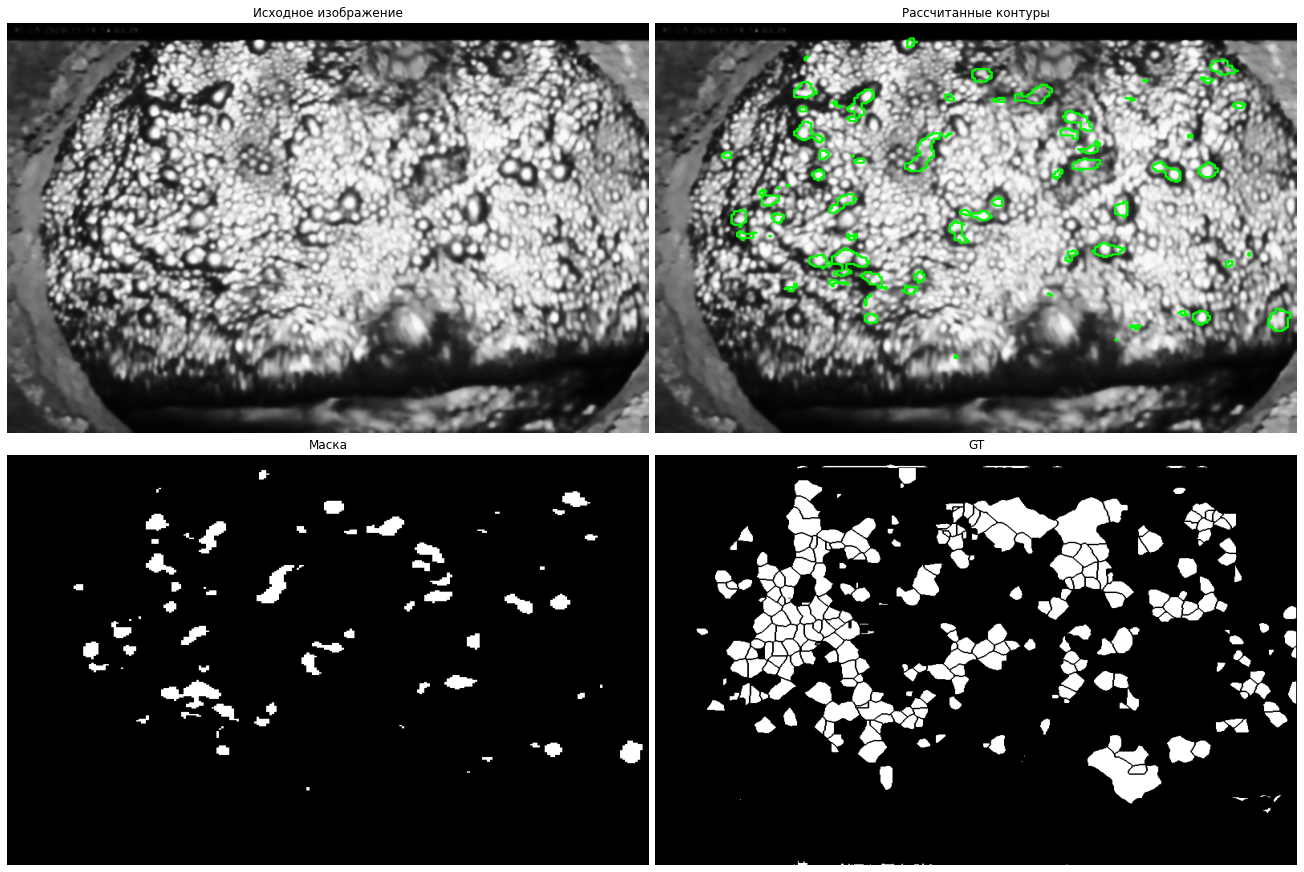

In [6]:
from  models.attunet import  *
if not os.path.exists('./results'):
    os.makedirs('./results')

if not os.path.exists('./weights'):
    os.makedirs('./weights')

if not os.path.exists('../data'):
    os.makedirs('../data')

generator = datagen('data/dataset', 'image', 'label', 'weights/unet_weights.pt', batch_size=1)
visualizer(generator)
